# Base Line Model Comparison

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv('Data/sampleDF.csv')
data.head(2)

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,_Season,_check_eq_publ
0,Digital,Freegal,SONG,2018,2,1,The Music Of The Night,Susan Boyle feat. Michael Crawford,Unknown,Unknown,9999,Winter,No
1,Digital,Freegal,SONG,2017,7,1,Opaline,Dishwalla,Unknown,Unknown,9999,Summer,No


In [10]:
data.UsageClass.value_counts()

Physical    80539
Digital     19461
Name: UsageClass, dtype: int64

In [4]:
from sklearn import preprocessing

In [5]:
#Function to label encode categories in a Dataframe

def encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [11]:
df_encoded, _ = encode_features(data)
df_encoded.head()

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,_Season,_check_eq_publ
0,0,0,15,2018,2,1,67551,32401,58248,11309,9999,3,0
1,0,0,15,2017,7,1,48784,8688,58248,11309,9999,2,0
2,1,2,18,2013,5,1,26636,23197,44689,1905,9999,1,0
3,1,2,2,2006,7,1,20272,27240,58248,7542,9999,2,0
4,1,2,2,2015,4,2,3782,8508,53849,4830,2010,1,0


### Define X and y

In [14]:
X = df_encoded.iloc[:,1:13]
X.head(2)

,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,_Season,_check_eq_publ
0,0,15,2018,2,1,67551,32401,58248,11309,9999,3,0
1,0,15,2017,7,1,48784,8688,58248,11309,9999,2,0


In [15]:
y = df_encoded.UsageClass

### Normalization

In [16]:
for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col]))

X.head()

,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,_Season,_check_eq_publ
0,0.0,0.625000,0.928571,0.090909,0.000000,0.741675,0.874214,0.921821,0.907697,1.000000,1.000000,0.0
1,0.0,0.625000,0.857143,0.545455,0.000000,0.535623,0.234412,0.921821,0.907697,1.000000,0.666667,0.0
2,0.5,0.750000,0.571429,0.363636,0.000000,0.292449,0.625880,0.707239,0.152902,1.000000,0.333333,0.0
3,0.5,0.083333,0.071429,0.545455,0.000000,0.222576,0.734965,0.921821,0.605346,1.000000,0.666667,0.0
4,0.5,0.083333,0.714286,0.272727,0.002439,0.041524,0.229555,0.852203,0.387672,0.020235,0.333333,0.0


## Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
print(y_train.value_counts())
print(y_test.value_counts())

1    60371
0    14629
Name: UsageClass, dtype: int64
1    20168
0     4832
Name: UsageClass, dtype: int64


---------
## Unbalanced Class

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score 

In [21]:
forest = RandomForestClassifier()

In [22]:
param_grid = {'n_estimators': [80, 100, 120],
              'criterion': ['gini', 'entropy'],
              'max_features': [3, 6, 8],         
              'max_depth': [5, 8, 10], 
              'min_samples_split': [3,5,8]}

forest_grid_search = GridSearchCV(forest, param_grid, cv=3, n_jobs=-1)
forest_grid_search.fit(X_train, y_train)
print(forest_grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 80}


In [23]:
# model with best parameters
forest = RandomForestClassifier(n_estimators=80, criterion='gini', max_depth=5, max_features=3, min_samples_split=3)

forest.fit(X_train, y_train)

forest_train_preds = forest.predict(X_train)
forest_test_preds = forest.predict(X_test)

forest_train_accuracy = accuracy_score(y_train, forest_train_preds)
forest_test_accuracy = accuracy_score(y_test, forest_test_preds)

forest_report = classification_report(y_test, forest_test_preds)

In [24]:
print(f"Training Accuracy: {(forest_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(forest_test_accuracy * 100):.4}%")

Training Accuracy: 100.0%
Test Accuracy:     100.0%


### XGBoost

In [26]:
import xgboost as xgb

In [27]:
xgboost = xgb.XGBClassifier()

In [28]:
param_grid = {'n_estimators': [50, 100, 500],
              'learning_rate': [0.05, 0.2], 
              'max_depth': [5, 8],
              'gamma': [0],
              'min_child_weight': [1],   # smaller value is chosen because it is a highly imbalanced class problem
              'scale_pos_weight':[1]}    # high class imbalance

xgb_grid_search = GridSearchCV(xgboost, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

print(xgb_grid_search.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'scale_pos_weight': 1}


In [29]:
# model with best parameters

xgb_model = xgb.XGBClassifier(gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, scale_pos_weight=1)

xgb_model.fit(X_train, y_train)

xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)
xgb_report = classification_report(y_test, xgb_test_preds)

In [30]:
print(f"Training Accuracy: {(xgb_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(xgb_test_accuracy * 100):.4}%")

Training Accuracy: 100.0%
Test Accuracy:     100.0%


### Support Vector Machine

In [31]:
from sklearn import svm

In [32]:
import seaborn as sns

In [33]:
svm = svm.SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=0)

svm.fit(X_train, y_train)

svm_train_preds = svm.predict(X_train)
svm_test_preds = svm.predict(X_test)

train_accuracy_svm = accuracy_score(y_train, svm_train_preds)
test_accuracy_svm = accuracy_score(y_test, svm_test_preds)
report_svm = classification_report(y_test, svm_test_preds)

In [34]:
print(f"Training Accuracy: {(train_accuracy_svm * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_svm * 100):.4}%")

Training Accuracy: 76.09%
Test Accuracy:     75.58%


In [35]:
print('Classification Report for SVM')
print(report_svm)

Classification Report for SVM
              precision    recall  f1-score   support

           0       0.44      0.97      0.61      4832
           1       0.99      0.70      0.82     20168

   micro avg       0.76      0.76      0.76     25000
   macro avg       0.71      0.84      0.71     25000
weighted avg       0.88      0.76      0.78     25000



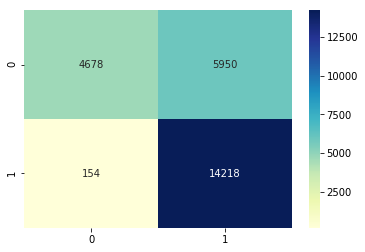

In [36]:
svm_matrix = confusion_matrix(svm_test_preds, y_test)
sns.heatmap(svm_matrix, cmap="YlGnBu", fmt='.16g', annot=True);

### KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
neigh = KNeighborsClassifier(algorithm='auto', weights='distance')

neigh.fit(X_train, y_train)

neigh_train_preds = svm.predict(X_train)
neigh_test_preds = svm.predict(X_test)

neigh_accuracy = accuracy_score(y_train, neigh_train_preds)
neigh_accuracy = accuracy_score(y_test, neigh_test_preds)
report_neigh = classification_report(y_test, neigh_test_preds)

In [39]:
print(f"Training Accuracy: {(neigh_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(neigh_accuracy * 100):.4}%")

Training Accuracy: 75.58%
Test Accuracy:     75.58%


In [40]:
print('Classification Report for KNN')
print(report_neigh)

Classification Report for KNN
              precision    recall  f1-score   support

           0       0.44      0.97      0.61      4832
           1       0.99      0.70      0.82     20168

   micro avg       0.76      0.76      0.76     25000
   macro avg       0.71      0.84      0.71     25000
weighted avg       0.88      0.76      0.78     25000



### Balancing Data - SMOTE

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
print('Class distribution from sample:')
print(data['UsageClass'].value_counts()) 

# resample data ONLY using training data
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train) 

print('Syntethic class distribution:')
print(pd.Series(y_resampled).value_counts())

Class distribution from sample:
Physical    80539
Digital     19461
Name: UsageClass, dtype: int64
Syntethic class distribution:
1    60371
0    60371
dtype: int64


In [43]:
# Split based on synthetic distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)

### Random Forest

In [46]:
forest = RandomForestClassifier(n_estimators=80, criterion='gini', max_depth=5, max_features=3, min_samples_split=3)

forest.fit(X_train, y_train)

forest_train_preds = forest.predict(X_train)
forest_test_preds = forest.predict(X_test)

forest_train_accuracy = accuracy_score(y_train, forest_train_preds)
forest_test_accuracy = accuracy_score(y_test, forest_test_preds)

forest_report = classification_report(y_test, forest_test_preds)

print(f"Training Accuracy: {(forest_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(forest_test_accuracy * 100):.4}%")

Training Accuracy: 100.0%
Test Accuracy:     100.0%


### XGB

In [47]:
xgboost = xgb.XGBClassifier()

xgb_model = xgb.XGBClassifier(gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, scale_pos_weight=1)

xgb_model.fit(X_train, y_train)

xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)
xgb_report = classification_report(y_test, xgb_test_preds)

print(f"Training Accuracy: {(xgb_train_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(xgb_test_accuracy * 100):.4}%")

Training Accuracy: 100.0%
Test Accuracy:     100.0%


### SVM

In [49]:
from sklearn import svm

In [50]:
svm = svm.SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=0)

svm.fit(X_train, y_train)

svm_train_preds = svm.predict(X_train)
svm_test_preds = svm.predict(X_test)

train_accuracy_svm = accuracy_score(y_train, svm_train_preds)
test_accuracy_svm = accuracy_score(y_test, svm_test_preds)
report_svm = classification_report(y_test, svm_test_preds)

print(f"Training Accuracy: {(train_accuracy_svm * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_svm * 100):.4}%")

Training Accuracy: 83.98%
Test Accuracy:     83.81%


In [51]:
print('\n SVM Report:')
print(report_svm)


 SVM Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     15042
           1       0.96      0.71      0.81     15144

   micro avg       0.84      0.84      0.84     30186
   macro avg       0.86      0.84      0.84     30186
weighted avg       0.86      0.84      0.84     30186



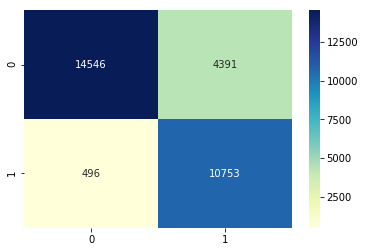

In [52]:
svm_matrix = confusion_matrix(svm_test_preds, y_test)
sns.heatmap(svm_matrix, cmap="YlGnBu", fmt='.16g', annot=True);

### KNN

In [54]:
neigh = KNeighborsClassifier(algorithm='auto', weights='distance')

neigh.fit(X_train, y_train)

neigh_train_preds = svm.predict(X_train)
neigh_test_preds = svm.predict(X_test)

neigh_accuracy = accuracy_score(y_train, neigh_train_preds)
neigh_accuracy = accuracy_score(y_test, neigh_test_preds)
report_neigh = classification_report(y_test, neigh_test_preds)

print(f"Training Accuracy: {(neigh_accuracy * 100):.4}%")
print(f"Test Accuracy:     {(neigh_accuracy * 100):.4}%")

Training Accuracy: 83.81%
Test Accuracy:     83.81%


In [55]:
print('\n KNN Report:')
print(report_neigh)


 KNN Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     15042
           1       0.96      0.71      0.81     15144

   micro avg       0.84      0.84      0.84     30186
   macro avg       0.86      0.84      0.84     30186
weighted avg       0.86      0.84      0.84     30186



### Note
Accuracy can be misleading, there is a large class imbalance in this eet, these models predicted the value of the majority class for all predictions and achieve a high classification accuracy, the problem is that they were not useful for our domain.

This models were run for comparison purposes. For this data set accuracy is an inadequate measure for quantifying predictive perfomance. Refer to notebook #4 for an evaluation of different metrics.